In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
pd.set_option('display.max_columns', 50)

In [2]:
df = pd.read_csv('../data/train.csv',dtype={'tipodepropiedad':'category','ciudad':'category','provincia':'category'})
df['fecha'] = pd.to_datetime(df['fecha'])
df['anio'] = df['fecha'].dt.year
df["mes"] = df['fecha'].dt.month
df["dia"] = df['fecha'].dt.day

df = df.drop(columns=["lat","lng"])

In [3]:
df["descripcion"] = df["descripcion"].fillna("")
df["titulo"] = df["titulo"].fillna("")

In [4]:
import re
import string
from stop_words import get_stop_words
from nltk.tokenize import word_tokenize

stopwords = get_stop_words('spanish')

def remove_stopwords(text,stopwords):
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stopwords] 
    filtered_sentence = []
    for w in word_tokens: 
        if w not in stopwords: 
            filtered_sentence.append(w)
    return " ".join(filtered_sentence)

def clean_text_round(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('ñ', 'n', text)
    text = re.sub('\[&;.*?¿\‘’“”…«»]\%;', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\w*\d\w*', ' ', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\x95', ' ', text)
    text = re.sub('acute', '', text)
    text = re.sub('tilde', '', text)
    text = re.sub(' p ', '', text)
    text = re.sub('nbsp', '', text)
    text = re.sub('á', 'a', text)
    text = re.sub('é', 'e', text)
    text = re.sub('í', 'i', text)
    text = re.sub('ó', 'o', text)
    text = re.sub('ú', 'u', text)
    return text

def limpiar_texto(text):
    return remove_stopwords(clean_text_round(text),stopwords)

In [5]:
df["descripcion"] = df["descripcion"].apply(limpiar_texto)

In [6]:
df["descripcion"].loc[218827]

'estrene departamento totales exterior piso elevador balcon vista calle estancia sala comedor cocina integral abierta barra granito cuarto lavado integrado recamara principal balcon walk in closet bano recamaras junior closet balcon interior bano completo cajones estacionamiento independientes techados condominio deptos elevador caseta vigilancia roof garden comun asador tarja medio bano ver video youtube buscando estrene departamento col valle http youtu be aceptamos creditos bancarios infonavit'

# Preprocess

In [7]:
import sys
from nltk import word_tokenize
from nltk import download
from nltk.corpus import stopwords

In [8]:
download('punkt') #tokenizer, run once
download('stopwords') #stopwords dictionary, run once
stop_words = stopwords.words('spanish')

[nltk_data] Downloading package punkt to /home/peter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/peter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
display(stop_words[:10])
print(f'Hay {len(stop_words)} stop words')

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se']

Hay 313 stop words


In [10]:
def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()] #restricts string to alphabetic characters only
    return doc

In [11]:
texts = df["descripcion"]

corpus = [preprocess(text) for text in texts]

# Word2Vec

In [12]:
from gensim.models import Word2Vec

In [13]:
import time

start_time = time.time()
model = Word2Vec(
        corpus,
        size=150,
        window=10,
        min_count=2,
        workers=10,
        iter=10)


print("--- %s seconds ---" % (time.time() - start_time))

--- 108.80923843383789 seconds ---


In [14]:
start_time = time.time()

model.train(corpus, total_examples=len(corpus), epochs=10)

print("--- %s seconds ---" % (time.time() - start_time))

--- 101.49614572525024 seconds ---


In [15]:
model.wv.most_similar(positive="garage")

[('garaje', 0.9525284171104431),
 ('cochera', 0.7534531950950623),
 ('estacionamiento', 0.7206419706344604),
 ('porch', 0.7029777765274048),
 ('grage', 0.6471502184867859),
 ('cohera', 0.6272969245910645),
 ('garageun', 0.58659428358078),
 ('chochera', 0.5745536684989929),
 ('garge', 0.553177535533905),
 ('cohcera', 0.5521492958068848)]

In [16]:
model.wv.most_similar(positive="depto")

[('departamento', 0.7858618497848511),
 ('depa', 0.6739681959152222),
 ('dpto', 0.6168169975280762),
 ('deptos', 0.6064167022705078),
 ('ph', 0.5970371961593628),
 ('habitables', 0.5343069434165955),
 ('penthouse', 0.48944416642189026),
 ('edif', 0.4883372187614441),
 ('quinto', 0.48764345049858093),
 ('noveno', 0.4855972230434418)]

In [17]:
model.wv.most_similar(positive="country")

[('mundet', 0.6226952075958252),
 ('jockey', 0.6141911149024963),
 ('golf', 0.6121260523796082),
 ('chivas', 0.6070430874824524),
 ('sonoma', 0.604469358921051),
 ('raqueta', 0.6043533086776733),
 ('hipico', 0.5990069508552551),
 ('britania', 0.5937023162841797),
 ('yacht', 0.5932648181915283),
 ('france', 0.5898220539093018)]

In [18]:
model.wv.most_similar(positive="privado")

[('cerrado', 0.6969057321548462),
 ('serrado', 0.576604962348938),
 ('bonterra', 0.54060959815979),
 ('exclusivo', 0.5300710201263428),
 ('cerrdo', 0.5276691317558289),
 ('salvaterra', 0.524071455001831),
 ('cerrrado', 0.4946379065513611),
 ('aile', 0.4908108115196228),
 ('viviendistico', 0.48742517828941345),
 ('vogilancia', 0.48458752036094666)]

In [19]:
model.wv.most_similar(positive="barrio")

[('poblado', 0.5846269726753235),
 ('historica', 0.5527140498161316),
 ('antigua', 0.5179954171180725),
 ('aurira', 0.513764500617981),
 ('casona', 0.5120511054992676),
 ('poblacion', 0.5079727172851562),
 ('callejon', 0.5061964392662048),
 ('catedral', 0.48914793133735657),
 ('franciscano', 0.48681315779685974),
 ('magdalena', 0.4866153299808502)]

In [20]:
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in word2vec_model.vocab]
    
    if (len(doc) != 0):
        return np.mean(word2vec_model[doc], axis=0)
    
    return np.zeros(word2vec_model.vector_size, dtype=np.float32)

In [21]:
def fit(corpus, word2vec_model):
    fitted_corpus = [document_vector(word2vec_model, doc) for doc in corpus]
    
    return fitted_corpus

In [22]:
fitted_corpus = fit(corpus, model.wv)

In [23]:
pepe = pd.DataFrame(np.array(fitted_corpus))
pepe.rename(columns={x:str(f"descripcion-feature-{y}") for x,y in zip(pepe.columns,range(0,len(pepe.columns)))}, inplace=True)

In [24]:
merged = df.join(pepe)

In [25]:
merged.to_csv('../data/words.csv', index=False)

In [26]:
pepe.to_csv('../data/word-features.csv', index=False)

# Reducción de dimensiones con Hashing Trick

In [27]:
import pandas as pd
pepe = pd.read_csv('../data/word-features.csv')

In [28]:
import category_encoders as ce

hash_trick = ce.HashingEncoder()
pepe_hash_trick = hash_trick.hashing_trick(pepe,N=30)

In [29]:
pepe_hash_trick.to_csv('../data/word-features-reduced.csv', index=False)

# Reducción de dimensiones con PCA

In [30]:
from sklearn.decomposition import PCA

pca = PCA(n_components=15, whiten = False)
pepe_pca = pca.fit_transform(pepe)

In [31]:
pepe_pca.shape

(240000, 15)

In [32]:
pepe_pca = pd.DataFrame(pepe_pca)
pepe_pca.rename(columns={x:str(f"descripcion-feature-{y}") for x,y in zip(pepe_pca.columns,range(0,len(pepe_pca.columns)))}, inplace=True)
pepe_pca


,descripcion-feature-0,descripcion-feature-1,descripcion-feature-2,descripcion-feature-3,descripcion-feature-4,descripcion-feature-5,descripcion-feature-6,descripcion-feature-7,descripcion-feature-8,descripcion-feature-9,descripcion-feature-10,descripcion-feature-11,descripcion-feature-12,descripcion-feature-13,descripcion-feature-14
0,-12.011022,2.376715,-0.371896,1.294995,-0.543803,-1.731025,-0.190390,-2.912175,-0.495883,-1.589385,1.336196,2.054008,-0.591391,0.334456,0.292309
1,-1.847010,0.680682,-2.031087,0.366682,6.208037,2.055222,1.054524,0.068045,0.361072,-0.209073,-0.496022,-0.567163,-0.907442,0.706306,-0.743353
2,4.671956,-1.249874,-1.093520,-1.554401,-0.370125,-0.899498,0.180867,0.712366,-1.246909,-0.290786,1.160878,-0.490641,0.699137,0.479224,0.274423
3,7.732163,1.730230,-0.155248,-1.306242,-0.025284,-1.201790,-1.190762,2.275234,-1.589299,-0.843261,0.823464,1.548676,2.350998,0.989693,-1.368399
4,5.924498,-0.494580,0.097739,3.761814,-0.388968,-0.356541,4.479202,-0.050531,-1.130621,1.761497,0.332489,1.271423,1.198450,-2.185835,2.445114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239995,4.738590,2.546663,0.142148,-1.001802,-0.726601,0.021692,-0.283606,1.555670,-0.360253,-0.544605,0.148879,1.247879,1.224685,0.695621,-0.576042
239996,0.508107,-0.303941,-0.182024,-0.745895,0.706646,-3.148146,-1.945933,-1.359158,-2.434363,1.060061,-0.419314,-0.270357,0.643315,0.368658,-0.174244
239997,-3.913456,-0.460272,-0.953363,4.312741,-0.955114,0.209945,-0.628316,1.327544,-0.215443,0.498452,-0.335385,0.169190,0.134843,-0.204849,0.500219
239998,-1.684901,-0.478754,1.802258,1.236221,-1.377138,2.298387,1.363540,-1.400392,1.522466,0.422435,2.692481,-0.911440,0.296388,-0.162964,-2.304936


In [33]:
pepe_pca.to_csv('../data/word-features-reduced.csv', index=False)

# Reducción de dimensiones con TSNE

In [68]:
from sklearn.manifold import TSNE
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 150), dtype='f')
    word_labels = [word]
    color_list  = ['green']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array

        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=11).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('Palabras parecidas a {}'.format(word.title())).set_size(30)

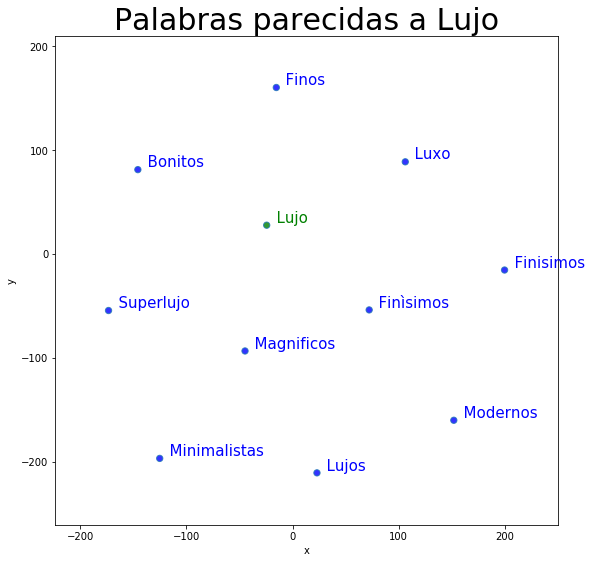

In [70]:
tsnescatterplot(model, 'lujo', [i[0] for i in model.wv.most_similar(negative=["lujo"])])